# Getting Started with COP Model Network Analysis

This starter notebook walks you through how to install the libraries necessary for our COP Model network analysis (NA), set up NA commands, and review and export the results.

## Install COPModel-NA

Highlight the following command and press Ctrl+C to copy it.

`git clone https://github.com/LetsCodePhysics/COPModel-NA.git`

In the JupyterHub folder, click on `New` $\rightarrow$ `Terminal`. Paste the command into the terminal using Ctrl+Shift+V.

This should create a new folder called COPModel-NA. 

You should only need to perform this installation once.

When that finishes, copy, paste and run

`pip install openpyxl`

Press Enter. You can close the terminal tab.

## Import Libraries

Run the code cell below to get started by clicking inside the code cell and pressing Ctlr+Enter. You shouldn't need to change anything about it. Scroll past it and continue reading at "COP Model Networks". This code cell imports all the other libraries we need.

In [2]:
# Import libraries.

import sys
sys.path.insert(0, 'COPModel-NA/') 
from copmodelna import *

import warnings
warnings.filterwarnings('ignore')
import datetime
import networkx as nx
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

## COP Model Networks

This Jupyter notebook reads in a spreadsheet of data from student COP model drawings, produces a set of **network diagrams**, and runs **bootstrap comparisons** of subnetworks made from student groups.

In a network diagram...

* Each circle (**node**) represents one drawing element.
* A node's **size** represents the element's **frequency**.
* Nodes are **color-coded** based on COP **categories**.
* Lines (**edges**) represent two elements occuring in the **same drawing**.
* A line's **thickness** represents **frequency of co-incidence**.

Bootstrapping is a randomization process that identifies effect sizes of differences between subnetworks.

The spreadsheet must be a Google Sheet formatted with columns as follows:
```
Element,Category,Drawing 1,Drawing 2,...
```
`Element` = List of individual elements found in the COP models. These are text cells.

`Category` = The type of COP element. This must be Member, Practice, Goal, or Demographic (used to filter drawings into subnetworks by student group). Any Demographic items must be included in the first M rows of the database; they cannot appear below Member, Practice, or Goal elements.

`Drawing N` = Did drawing N include this element? If yes, the cell = y. If no, it's empty. (For demographic lines, this cell includes demographic info.)

Here is the link to our spreadsheet for instructional labs: https://docs.google.com/spreadsheets/d/1TGk3QrpYbnSmVDT-c52PDL_ysp115mEm_mloAbwPRIs/edit?gid=0#gid=0

## Read in the spreadsheet.

To get started, you need to **read in the spreadsheet**. Run the code cell below.

*If you need to use a different spreadsheet* for a different set of data, just replace the Google Sheet ID located in `https://docs.google.com/spreadsheets/[Google Sheet ID goes here]/export` with your own. Note that the data will be pulled from the *leftmost tab* in the spreadsheet.

In [9]:
# Read in the spreadsheet.

full_database = pd.read_excel("https://docs.google.com/spreadsheets/d/1TGk3QrpYbnSmVDT-c52PDL_ysp115mEm_mloAbwPRIs/export",engine='openpyxl')

## Create a network to study.

The next step is to **create a list** of the drawings you want to include in your analysis. To do this, use the `MakeSubgroup` function. This function requires at least one input argument: `full_database` is the name of the database created by calling `pd.read_excel` above.

By default, `MakeSubgroup(full_database)` will create a network using **all** the drawings in `full_database`. You can add more input arguments to `MakeSubgroup` to **filter** the drawings in the network. Just follow the pattern `MakeSubgroup(full_database,'row name 1','value 1','row name 2','value 2')` where...
* `'row name'` is the name of a **row** in the spreadsheet (such as `'Gender'`, `'Lab Name'`, or the name of an element).
* `'value'` is the **value** you want the drawings in your network to have (such as `'female'`, `'ipls'`, or `'y'` to check for an element).

Here are a few examples of using `MakeSubgroup`:
* `ipls_drawings = MakeSubgroup(full_database,'Lab Name','ipls')` will create a list of all drawings about the ipls lab, and store that list under the variable name `ipls_drawings`.
* `ipls_female_drawings = MakeSubgroup(full_database,'Lab Name','ipls','Gender','female')` will create a list of all drawings about the ipls lab made by female students, and store that list under the variable name `ipls_female_drawings`.
* `ipls_firstgen_drawings = MakeSubgroup(full_database,'Lab Name','ipls','First Gen',True)` will create a list of all drawings about the ipls lab made by first-generation college students, and store that list under the variable name `ipls_firstgen_drawings`. (Note that, in our spreadsheet, `'First Gen'` values are boolen True or False, not strings, and therefore the `True` in this example does not have quotation marks around it.)
* `ipls_asian_drawings = MakeSubgroup(full_database,'Lab Name','ipls','Asian',True)` will create a list of all drawings about the ipls lab made by Asian students, and store that list under the variable name `ipls_asian_drawings`. (Again, note that this demographic row uses boolean values, not strings.)

The resulting list looks like this:

`['Drawing 1', 'Drawing 2', 'Drawing 5', ...]`

Each **element** in this list is just the column label for the drawing that's included in the subnetwork. Other functions use will use these lists to look up the drawings that are included and ignore the drawings that aren't included.

Once you have these lists, you can **manipulate** them using [Python list operations](https://www.geeksforgeeks.org/python-lists/). For example...

* Suppose you have a reason for **excluding** Drawing 16 from your analysis of `ipls_female_drawings`. You can remove it using `ipls_female_drawings.remove('Drawing 16')`. 

* Or suppose you want to **combine** two lists, like `ipls_female_drawings` and `ipls_firstgen_drawings`. Since these lists likely have some drawings in common (i.e., drawings from first-generation female students), we can use `combined_list = list(set(ipls_female_drawings).union(ipls_firstgen_drawings))` to combine the lists and avoid duplicates. Here, the `set` and `union` functions take in a list and produce a set of items with no duplicates. The `list` function then turns the resulting set back into a list.

* Or suppose you want to create a list of drawings that **does include the drawings** in another list. For example, suppose you had a list `male_ipls_drawings = MakeSubgroup(full_database,'Lab Name','ipls','Gender','male')` and wanted all the drawings from non-male students. You can use `nonmale_ipls_drawings = list(set(ipls_drawings) - set(male_ipls_drawings))`. Here, the `-` operator removes items the two sets have in common.

In [4]:
# Create a list for your network.

my_list = MakeSubgroup(full_database)

# You can print the list to check that it has the contents you expected.

print(my_list)

# Or you can check the length of the list to see how many drawings it has.

print(len(my_list))

['Drawing 1', 'Drawing 2', 'Drawing 3', 'Drawing 4', 'Drawing 5', 'Drawing 6', 'Drawing 7', 'Drawing 8', 'Drawing 9', 'Drawing 10', 'Drawing 11', 'Drawing 12', 'Drawing 13', 'Drawing 14', 'Drawing 15', 'Drawing 16', 'Drawing 17', 'Drawing 18', 'Drawing 19', 'Drawing 20', 'Drawing 21', 'Drawing 22', 'Drawing 23', 'Drawing 24', 'Drawing 25', 'Drawing 26', 'Drawing 27', 'Drawing 28', 'Drawing 29', 'Drawing 30', 'Drawing 31', 'Drawing 32', 'Drawing 33', 'Drawing 34', 'Drawing 35', 'Drawing 36', 'Drawing 37', 'Drawing 38', 'Drawing 39', 'Drawing 40', 'Drawing 41', 'Drawing 42', 'Drawing 43', 'Drawing 44', 'Drawing 45', 'Drawing 46', 'Drawing 47', 'Drawing 48', 'Drawing 49', 'Drawing 50', 'Drawing 51', 'Drawing 52', 'Drawing 53', 'Drawing 54', 'Drawing 55', 'Drawing 56', 'Drawing 57', 'Drawing 58', 'Drawing 59', 'Drawing 60', 'Drawing 61', 'Drawing 62', 'Drawing 63', 'Drawing 64', 'Drawing 65', 'Drawing 66', 'Drawing 67', 'Drawing 68', 'Drawing 69', 'Drawing 70', 'Drawing 71', 'Drawing 72', 

## Create and visualize the graph.

The list you just created tells Python **which drawings to include in a graph**. A graph is a Python object that stores information about nodes and edges. To create a graph object from your list of drawings, use `G_name = MakeGraph(my_list,full_database)`. Here, `my_list` is the list of drawings you created, and `full_database` is the name of the database created by calling `pd.read_excel` above. Make sure to give your graph a name that you can associate with the list (something more specific than `G_name` here).

Creating the graph can take some time, so you should usually run this function in its own code cell and be prepared to take a little break while it runs.

After you create the graph, create a **network diagram** of it using the `DrawGraph(G_name)` function. `DrawGraph` requires one input, the name of the graph you created using `MakeGraph`. It will produce a graphic of the network diagram in the output below the code cell.

If your network diagram is difficult to examine (for example, the nodes are too small or too big), you can also provide the following optional arguments to adjust its appearance: 
* `node_size_control` is a number that adjusts the size of the nodes
* `edge_size_control` is a number that adjusts the size of the edges
* `fig_size` is a tuple of two numbers (x,y) that controls the size of the figure
* `font_size` is a number that controls the size of the text font in the graph

So, if you wanted a huge figure with tiny nodes, you could use `DrawGraph(G_name,node_size_control=0.1,figsize=(100,100))`.

Also note that Jupyter **can't display more than one network diagram from each code cell**. This means if you use `DrawGraph` multiple times in a single code cell, it will show only the last one.

Once you have your network diagram, you can right-click and save the image to your computer for use in a paper, email, etc.

Finally, there's one more argument you might need later: `pos` is a dictionary that controls where each node is placed. You'll need to use `pos` to compare graphs of two subnetworks with their nodes in consistent positions. Here's how you use it:

1. When you use `MakeGraph` for the first graph, you need to store its `pos` as an output: `pos1 = MakeGraph(G1)`.
2. Then, when you use `MakeGraph` for the second network, you need to add that `pos` output as an input: `MakeGraph(G2,pos=pos1)`. 
3. When you compare the network diagrams for `G1` and `G2`, the same nodes hold the same positions, allowing you to visually compare their place within each network.

In [5]:
# Create a graph.

G_name = MakeGraph(my_list,full_database)

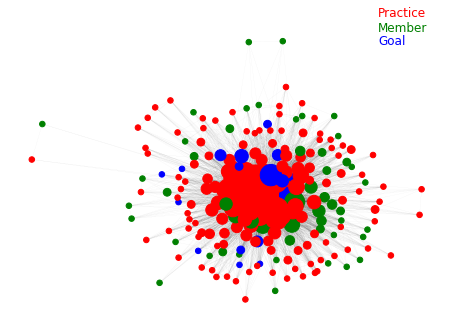

In [7]:
# Create network diagram.

pos = DrawGraph(G_name)

## Analyze the graph.

*Last updated 8May2025.*

Once you have a graph made (let's keep calling it `G_name`), there are many functions you can use to analyze it. Which functions you use depends on your research question, but here are the ones I've found most useful so far. Keep an eye out for updates in this section as we add more functions.

* `nx.density(G)` will give the **density** of graph `G`. This value ranges from 0 to 1 and represents how well connected the nodes are compared to how connected they could be.

* `G.degree('node')` will give the degree of the node named `'node'` in graph `G`. This gives you a number that tells you how many edges come out of the node named `'node'`.

* `NodeStrength(G,'node')` is a number equal to the sum of all the edge weights coming out of the node named `'node'` in graph `G`.

* `nx.betweenness_centrality(G)['node']` will give the fraction of times node `'n'` acts as a bridge along the shortest path linking two other nodes in the graph `'G'`. This returns a number between 0 and 1. If you add the argument `weight = 'weight_inverse'` after the `'G'`, it will weight these paths by 1 / the edge weight, making stronger connections a shorter distance.

* `AllStrength(G)` is the total of all nodes' strengths (from `'NodeStrength'`) across network `'G'`. This is also the sum of all y's in the original database.

* `clusters = DetectClusters(G_name,weight='weight',method='method')` This function partitions your graph into **clusters**. ("Clusters" are sometimes called "communities" in the literature, but we're already using the word "community" to refer to a community of practice. Just keep that in mind while you compare our work with the literature.) A cluster is a set of nodes that are more connected to each other than they are to other nodes in the graph. There are many methods you can specify in this function; we use `'fast-greedy'` as a default for now but that might change. The output `clusters` is a set of lists, with each list containing the nodes in a given cluster.

* `Modularity(G,clusters)` is a number between -1 and 1 that measure of how well the graph `'G'` was separated into the list of clusters you obtained from `DetectClusters`.

* `PurityOfClustering(clusters,other_clusters)` takes in two lists of clusters you obtained from `DetectClusters`, each for a different graph, and gives a number between 0 and 1 telling you how much overlap there is between the two clusters (0 being none, and 1 being a perfect match). We will usually run `PurityOfClustering` with arguments `(G_all_clusters,G_subset_clusters)` where `G_all_clusters` is the list of clusters for the full data set and `G_subset_clusters` is the list of clusters for the subset of data you're exploring.

* `FMeasure(clusters,other_clusters)` is similar to purity ([citation](https://www.sciencedirect.com/science/article/pii/S0378873321000307?casa_token=Y4KM5fBX43MAAAAA:ivqcUlFsXD2HZwQ5_QMvKApMMx85F0kiFqWw5PQCYANsXKqLh0_AzIx1BHbm3KS0m_Z5UpDNvc4#:~:text=2.3.2.-,F%2DMeasure,-The%20F%2DMeasure)).

* `RunBootstrap(drawings,full_database,N,subset_name,N_nodes,nodes_you_want,file_out,time_print,min_node_weight,nodes_in,num_sig,cap_edge_weight,measures_in_table)` carries out `N` bootstraps on the subnetwork of list `drawings`. A **bootstrap** is a clone of a network where the edge weights have been randomized using a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). By running many (usually 1000-2000) bootstraps, we can obtain an average and standard deviation for each node's centrality measures. `RunBootstrap` has many arguments, but everything after `full_database` is optional and will use a default value if you omit it:

  * `drawings` = the list of drawings in the subnetwork
  * `full_database` = the database from `pd.read_excel`
  * `N` = the number of bootstraps (optional; default 1200)
  * `subset_name` = a string with the name of the subset (e.g., `Female IPLS`) to list in the output file (optional; default uses the variable name you provided for `drawings`)
  * `N_nodes` = the number of highest-frequency nodes to include in the output table (optional; default 5)
  * `nodes_you_want` = a list of node names formatted as strings for nodes you want to include in the output table *in addition to* the `N_nodes` highest-frequency nodes (optional; default empty list)
  * `file_out` = a string with the name of the .txt output file you'd like to use (optional; default uses the current date and time and `subset_name`
  * `time_print` = True or False, whether you want to see how much time the function spends in each bootstrap (optional; default False)
  * `min_node_weight` = number for the minimum frequency of nodes to include in the network. Lower-frequency nodes will be omitted (optional; default 5).
  * `nodes_in` = a list of node names you want to include in the network. This overrides `min_node_weight`, and is used if you have a list of nodes from another network and you want this network to use the exact same set of nodes (optional; if omitted, the network includes nodes with frequency >= `min_node_weight`).
  * `num_sig` = number of significant digits to use in output table (optional; default 3)
  * `cap_edge_weigh` = True or False, whether you want to maximize edge weights in the bootstrap process to the frequency of the connected nodes (optional; default True). This has some influence on effect sizes, so just always be consistent with your choice in a given study.
  * `measures_in_table` = a list of strings specifying the types of centrality measures you want to include in the output table. Currently, we only use the default of `['frequency','betweenness']`, since other centrality measures haven't been giving us reasonable results. This might change as we collect data from a larger sample size (optional; default `['frequency','betweenness']`).

`RunBootstrap` gives lots of output in a few places for redundancy. All output is printed to the screen, written to `file_out`, and stored in a few variables. When you use `RunBootstrap`, you need to specify three variables as output:

`big_nodes,centralities,n = RunBootstrap(...)`

where `big_nodes` is a list of the names of the nodes included in the output tables, `centralities` is a dictionary of all centrality values determined along with their means and standard deviations, and `n` is the number of drawings in the subnetwork. To review the contents of `centralities`, you can use `print(centralities)` to see everything and `print(centralities['item name'])` to see the value for a particular item within.

In `file_out`, you'll see an information dump of essentially everything from `RunBootstrap`. You can review [the source code here](https://github.com/LetsCodePhysics/COPModel-NA/blob/main/copmodelna.py) (Ctrl+F and look for "def RunBootstrap"), then look for `convert_file.write` commands to see what it's outputing.

In [ ]:
# Use analysis functions here.


## Compare multiple networks.

When you have multiple networks, you can compare them using the following functions:
  
* `NodeDegreeCosine(G1,G2)` will compare the node degrees between graphs `'G1'` and `'G2'`. It returns a value between 0 and 1. If the two graphs are similar, the value is closer to 1. If the two graphs are different, the value is closer to 0.

* `NodeStrengthCosine(G1,G2)` will compare the node strengths between graphs `'G1'` and `'G2'`. It returns a value between 0 and 1. If the two graphs are similar, the value is closer to 1. If the two graphs are different, the value is closer to 0.

* `NodeWeightCosine(G1,G2)` will compare the node weights between graphs `'G1'` and `'G2'`. It returns a value between 0 and 1. If the two graphs are similar, the value is closer to 1. If the two graphs are different, the value is closer to 0.

* `EEJ(G1,G2)` will compare the existence of edges between graphs `'G1'` and `'G2'`. It returns a value between 0 and 1. If the two graphs are similar, the value is closer to 1. If the two graphs are different, the value is closer to 0.

But the **most important** comparison to make is a full bootstrap comparison between two or more subnetworks to determine whether the differences between them show large effect sizes. The most direct way to do this is the `CompareGroups(list_of_groups,full_database,N,min_node_weight,group_names,N_nodes,nodes_you_want,file_out,num_sig,clustering_method,measures_in_table=['betweenness'])` function. Its inputs are...

* list_of_groups = a list of groups of students. The first group MUST be the full network. Each group should be a list created by MakeSubgroup().                     |
* group_names = a list of names for each group. The first group MUST be the full network.
* full_database = the pandas database you read in from Google Sheets
* N = the number of bootstrap iterations (default 1200)
* min_node_weight = the minimum weight of nodes to include (default 5). Nodes with frequency less than this value will be exlucded.
* N_nodes = the number of highest-frequency nodes to include in the export table (default 20)
* nodes_you_want = a list of additional nodes you want to include in the export table
* file_out = the name of the file to write the export table (must end with .txt). This will default to the date and time . txt. A file for each group will have the same name prepended with the group name.
* num_sig = the number of significant digits you want in the output table (default 3)         |
* cap_edge_weight = whether you want to maximize the edge weight randomization by each node's frequency (default False)
* measures_in_table = list of the measures to include in the output table. Currently only frequency and betweenness are implemented.
* clustering_method = method employed to identify clusters of nodes (default fast-greedy)     |

This function produces a lot of output to a single dictionary, the screen, and your `file_out`. Most importantly, it creates a $LaTeX$-formatted table in `file_out` with the centrality values and effect sizes we can use in a publication. When needed, we can import this table into Excel and remove the $LaTeX$ formatting in a few minutes.

**`CompareGroups` takes the longest to run** but it completes all steps of analysis we need to compare the drawings from two subpopulations.

In [ ]:
# Run CompareGroups here.

output = CompareGroups() # Add the arguments you want. Run with no arguments to get an explainer.

## When you need to update COPModel-NA...

Occaissionally we'll update the COPModel-NA library with new features. When you need to update the library, highlight the following command and press Ctrl+C to copy it.

`cd COPModel-NA ; git pull https://github.com/LetsCodePhysics/COPModel-NA.git`

Click on `New` $\rightarrow$ `Terminal`. Paste the command into the terminal using Ctrl+Shift+V.

Press Enter.

This should update the COPModel-NA library. You can close the terminal tab. Back in the Jupyter notebook, make sure you re-run the code cell where you have `from copmodelna import *` to update the library within the Jupyter notebook.